# Skills2Vec

Event log
- data ingeladen
- descriptions opgebroken in losse zinnen
- simpele schoonmaak gedaan:
    - alles naar lowercase
    - alleen woorden met tekst characters erin worden meegenomen
- de losse zinnen ook weer opgebroken in losse woorden en zo het word2vec model getrained
- er kon nu een lijst uitgedraaid worden van woorden die (op basis van het corpus) overeenkomen.
- Per aanvraag kan een top 10 aan gelijke woorden worden uitgedraaid.



TODO:
 - beter cleanen
     - stopwoorden
     - capitalization
     - interpunctie 
     - ordinale in meewerken
 - skills kant verwerken
 - globaal model trainen
 - Bijhouden van event log
 - Labelen van informatie (ORG, Name etc.)!!!

## Imports

In [9]:
!pip install nltk
!pip install gensim

  Using cached nltk-3.2.5.tar.gz
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/18/9c/1f/276bc3f421614062468cb1c9d695e6086d0c73d67ea363c501
Successfully built nltk


In [10]:
from __future__ import absolute_import, division, print_function

In [11]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [12]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [14]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [15]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("maxent_ne_chunker")
nltk.download('words')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [16]:
skills_aanvragen = pd.read_csv('/home/jovyan/work/data/KPN Consulting - Aanvragen.csv', encoding='latin-1', sep=';')
skills_skills = pd.read_csv('/home/jovyan/work/data/Job History DATA.csv', encoding='latin-1', sep=';')

In [67]:
#merge 2 skills & aanvragen
list1 = list(skills_aanvragen['Description'].dropna().values)
list2 = list(skills_skills['Short Description'].dropna().values)
combinatie = list1 + list2


In [49]:
ndf = skills_skills[['Job Title', 'Short Description']].dropna()

aanvraag_ndf = skills_aanvragen[['Name', 'Description']]
aanvraag_ndf["CleanName"] = aanvraag_ndf.Name.apply(lambda x: "".join(x.split()[1:]))
aanvraag_ndf = aanvraag_ndf[["CleanName", 'Description']].dropna()

skills_agg = ndf.groupby('Job Title')['Short Description'].apply(lambda x: list(x))
aanvraag_agg = aanvraag_ndf.groupby('CleanName')['Description'].apply(lambda x: list(x))

def build_list(job_agg):
    a = ""
    for i in job_agg:
        try:
            a += i
        except TypeError:
            #print(i)
            pass
    return a

def get_description_mapping(skills_agg, titles):
    mapping = {}
    for title in titles:
        mapping[title] = build_list(skills_agg[title])
    return mapping


description_mapping = get_description_mapping(skills_agg, ndf['Job Title'].unique())
aanvraag_mapping = get_description_mapping(aanvraag_agg, aanvraag_ndf['CleanName'].unique())


#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.lower().split()
    return words

def get_sentences(sent_list):
    sent_list = map(lambda x: unicode(x.lower()), sent_list)
    sentences = map(sentence_to_wordlist, sent_list)
    return sentences

        

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Train Word2Vec

In [17]:

num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1

aanvraag_model = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)
skills_model = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)
combinatie_model = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [63]:
l1_sentences = get_sentences(list1)
l2_sentences = get_sentences(list2)
combinatie_sentences = get_sentences(combinatie)

In [43]:
aanvraag_model.build_vocab(l1_sentences)
skills_model.build_vocab(l2_sentences)
combinatie_model.build_vocab(combinatie_sentences)


2017-09-27 09:29:22,627 : INFO : collecting all words and their counts
2017-09-27 09:29:22,632 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-09-27 09:29:22,747 : INFO : PROGRESS: at sentence #10000, processed 373425 words, keeping 18138 word types
2017-09-27 09:29:22,752 : INFO : collected 18312 word types from a corpus of 384266 raw words and 10671 sentences
2017-09-27 09:29:22,754 : INFO : Loading a fresh vocabulary
2017-09-27 09:29:22,865 : INFO : min_count=3 retains 7718 unique words (42% of original 18312, drops 10594)
2017-09-27 09:29:22,868 : INFO : min_count=3 leaves 370939 word corpus (96% of original 384266, drops 13327)
2017-09-27 09:29:22,891 : INFO : deleting the raw counts dictionary of 18312 items
2017-09-27 09:29:22,894 : INFO : sample=0.001 downsamples 36 most-common words
2017-09-27 09:29:22,896 : INFO : downsampling leaves estimated 288002 word corpus (77.6% of prior 370939)
2017-09-27 09:29:22,898 : INFO : estimated required memory 

**Start training, this might take a minute or two...**

In [46]:
aanvraag_model.train(l1_sentences, 
                  total_examples=aanvraag_model.corpus_count,
                 epochs=aanvraag_model.iter)
skills_model.train(l2_sentences, 
                  total_examples=skills_model.corpus_count,
                 epochs=skills_model.iter)
combinatie_model.train(combinatie_sentences, 
                  total_examples=combinatie_model.corpus_count,
                 epochs=combinatie_model.iter)

2017-09-27 09:35:41,771 : INFO : training model with 1 workers on 7718 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-09-27 09:35:42,844 : INFO : PROGRESS: at 4.11% examples, 75765 words/s, in_qsize 2, out_qsize 0
2017-09-27 09:35:43,893 : INFO : PROGRESS: at 9.74% examples, 77286 words/s, in_qsize 2, out_qsize 0
2017-09-27 09:35:44,894 : INFO : PROGRESS: at 15.69% examples, 78997 words/s, in_qsize 2, out_qsize 0
2017-09-27 09:35:45,911 : INFO : PROGRESS: at 21.70% examples, 79300 words/s, in_qsize 2, out_qsize 0
2017-09-27 09:35:46,922 : INFO : PROGRESS: at 26.88% examples, 79612 words/s, in_qsize 2, out_qsize 0
2017-09-27 09:35:47,952 : INFO : PROGRESS: at 32.79% examples, 79778 words/s, in_qsize 2, out_qsize 0
2017-09-27 09:35:48,961 : INFO : PROGRESS: at 39.97% examples, 80114 words/s, in_qsize 2, out_qsize 0
2017-09-27 09:35:49,997 : INFO : PROGRESS: at 44.09% examples, 79827 words/s, in_qsize 2, out_qsize 0
2017-09-27 09:35:51,089 : INFO : PROG

2426180

In [56]:
##########################################################
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint

def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = map(lambda x: x.lower(), clean.split())
    words = clean_wordlist(words)
    return words

def clean_wordlist(words):
    global swords
    new_words = []
    for word in words:
        if word not in swords:
            new_words.append(word)
    return " ".join(new_words)



swords = [eval('stopwoorden{}'.format(i)) for i in range(1,7)]
swords = [i for j in swords for i in j]

def get_clean_description_mapping(skills_agg):
    clean_description_mapping = {}
    for key, value in zip(skills_agg.keys(), list(skills_agg.values)):
        words = map(sentence_to_wordlist, value)
        clean_description_mapping[key] = map(lambda x: x.split(), words)
    return clean_description_mapping
    
    
clean_description_mapping = get_clean_description_mapping(skills_agg)
clean_aanvraag_mapping = get_clean_description_mapping(aanvraag_agg)

In [57]:
key = 'Consultant'
key, clean_aanvraag_mapping[key]

('Consultant',
 [[u'doel',
   u'inzet',
   u'kpn',
   u'consulting',
   u'ondersteunen',
   u'nodig',
   u'sccm',
   u'project',
   u'sbc',
   u'hix',
   u'kortom',
   u'consultant',
   u'sccm',
   u'specialist',
   u'ingezet',
   u'daarnaast',
   u'aangegeven',
   u'erasmus',
   u'mc',
   u'dezelfde',
   u'consultant',
   u'graag',
   u'inzetten',
   u't',
   u'b',
   u'v',
   u'implementatie',
   u'office',
   u'upgrade',
   u'huidige',
   u'sccm',
   u'omgeving'],
  [u'plan',
   u'aanpak',
   u'schrijven',
   u'bedrijfsonderdelen',
   u'topdesk',
   u'werken',
   u'overgaan',
   u'servicenow',
   u'persoon',
   u'gaat',
   u'gesprekken',
   u'stakeholders',
   u'voeren',
   u'gebeuren',
   u'zowel',
   u'inhoudelijk',
   u'nta'],
  [u'hhnk',
   u'hoogheemraadschap',
   u'hollands',
   u'noorderkwartier',
   u'heerhugowaard',
   u'bezig',
   u'dubbelle',
   u'moo',
   u'oplossing',
   u'implementeren',
   u'verbindingen',
   u'actief',
   u'passief',
   u'laten',
   u'werken',
   u'h

In [60]:
key = 'Business Consultant'
key, clean_description_mapping[key]

('Business Consultant',
 [[u'adviserende',
   u'rol',
   u'project',
   u'smart',
   u'buildings',
   u'fontys',
   u'hogeschool',
   u'mogelijk',
   u'data',
   u'analyses',
   u'inventariseren',
   u'uitvoeren',
   u'data',
   u'analyses',
   u'samenwerking',
   u'studenten',
   u'adviseren',
   u'mbt',
   u'impact',
   u'organisatie'],
  [u'kpn',
   u'onderzoek',
   u'meten',
   u'weten',
   u'uitgevoerd',
   u'status',
   u'ict',
   u'hieruit',
   u'meerdere',
   u'risico',
   u's',
   u'voren',
   u'gekomen',
   u'waarvoor',
   u'aanbevelingen',
   u'gedaan',
   u'deel',
   u'aanbevelingen',
   u'mogelijk',
   u'belegd',
   u'beheer',
   u'projecten',
   u'actieplan',
   u'opgesteld',
   u'belegde',
   u'aanbevelingen',
   u'uitgewerkt',
   u'werkpakketten',
   u'hiermee',
   u'umcg',
   u'juiste',
   u'resources',
   u'alloceren',
   u'gestructureerd',
   u'vorm',
   u'gegeven',
   u'opvolging'],
  [u'verband',
   u'vele',
   u'veranderingen',
   u'organisatie',
   u'behoefte',
 

In [73]:
from operator import itemgetter



aanvraag_key = 'Consultant'
aanvraag_dictionary = corpora.Dictionary(clean_aanvraag_mapping[aanvraag_key]) #(word_id,frequency) pairs

corpus = [dictionary.doc2bow(text) for text in map(lambda x: x.split(), combinatie_sentences)] 

#Set parameters
num_topics = 10 #The number of topics that should be generated
passes = 10 


aanvraag_lda = LdaModel(corpus,
              id2word=aanvraag_dictionary,
              num_topics=num_topics,
              passes=passes)

aanvraag_lda.get_document_topics(corpus[0], minimum_probability=0.05, per_word_topics=False)
sorted(aanvraag_lda.get_document_topics(corpus[0],minimum_probability=0,per_word_topics=False),key=itemgetter(1),reverse=True)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(aanvraag_lda.print_topics(num_words=5))

2017-09-27 15:05:32,585 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-09-27 15:05:32,593 : INFO : built Dictionary(1828 unique tokens: [u'documenteren', u'all', u'digitaal', u'erachteraan', u'hermans']...) from 338 documents (total 4344 corpus positions)
2017-09-27 15:05:33,127 : INFO : using symmetric alpha at 0.1
2017-09-27 15:05:33,130 : INFO : using symmetric eta at 0.00054704595186
2017-09-27 15:05:33,133 : INFO : using serial LDA version on this node
2017-09-27 15:05:33,387 : INFO : running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 19046 documents, updating model once every 2000 documents, evaluating perplexity every 19046 documents, iterating 50x with a convergence threshold of 0.001000
2017-09-27 15:05:33,389 : INFO : PROGRESS: pass 0, at document #2000/19046
2017-09-27 15:05:39,647 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:05:39,657 : INFO : topic #6 (0.100): 0.038*"

2017-09-27 15:05:50,935 : INFO : topic #3 (0.100): 0.034*"doel" + 0.033*"componenten" + 0.031*"vault" + 0.026*"benodigd" + 0.023*"vivare" + 0.017*"werkprocessen" + 0.015*"interviews" + 0.014*"hsrp" + 0.012*"information" + 0.012*"gestelde"
2017-09-27 15:05:50,938 : INFO : topic #9 (0.100): 0.085*"control" + 0.039*"doel" + 0.021*"hoogheemraadschap" + 0.019*"procedures" + 0.018*"analyse" + 0.018*"gesprekken" + 0.017*"werkprocessen" + 0.017*"ingezet" + 0.016*"operatie" + 0.015*"processen"
2017-09-27 15:05:50,940 : INFO : topic #0 (0.100): 0.108*"voorkeur" + 0.108*"gateways" + 0.106*"beheer" + 0.034*"interface" + 0.033*"heerhugowaard" + 0.023*"graaf" + 0.023*"hierop" + 0.019*"vaardig" + 0.016*"middelss" + 0.015*"topdesk"
2017-09-27 15:05:50,941 : INFO : topic #6 (0.100): 0.070*"gesprekken" + 0.036*"zowel" + 0.031*"gemeenten" + 0.027*"processen" + 0.025*"ns" + 0.022*"beheeromgeving" + 0.020*"opzoek" + 0.019*"samengesteld" + 0.018*"hsrp" + 0.016*"delta"
2017-09-27 15:05:50,942 : INFO : topic 

2017-09-27 15:06:00,579 : INFO : topic diff=0.297728, rho=0.301511
2017-09-27 15:06:00,583 : INFO : PROGRESS: pass 1, at document #4000/19046
2017-09-27 15:06:02,122 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:06:02,142 : INFO : topic #6 (0.100): 0.068*"gesprekken" + 0.047*"gemeenten" + 0.045*"zowel" + 0.031*"beheeromgeving" + 0.024*"opzoek" + 0.022*"processen" + 0.020*"assistance" + 0.016*"hsrp" + 0.016*"ns" + 0.015*"topdesk"
2017-09-27 15:06:02,145 : INFO : topic #5 (0.100): 0.032*"samenwerkingsverband" + 0.021*"toekomstige" + 0.019*"huidige" + 0.017*"gemeenten" + 0.017*"wijki" + 0.016*"topdesk" + 0.015*"cadcam" + 0.014*"junioren" + 0.014*"apeldoorn" + 0.014*"gebied"
2017-09-27 15:06:02,147 : INFO : topic #3 (0.100): 0.033*"doel" + 0.027*"benodigd" + 0.022*"vivare" + 0.022*"persoon" + 0.019*"information" + 0.019*"zaken" + 0.017*"things" + 0.016*"module" + 0.015*"huidige" + 0.014*"uitgerold"
2017-09-27 15:06:02,149 : INFO : topic #4 (0.10

2017-09-27 15:06:11,218 : INFO : topic #9 (0.100): 0.060*"control" + 0.045*"doel" + 0.027*"hoogheemraadschap" + 0.026*"analyse" + 0.022*"operatie" + 0.019*"ingezet" + 0.015*"afstand" + 0.015*"procedures" + 0.015*"bestaande" + 0.014*"interface"
2017-09-27 15:06:11,218 : INFO : topic diff=0.181753, rho=0.301511
2017-09-27 15:06:11,220 : INFO : PROGRESS: pass 1, at document #16000/19046
2017-09-27 15:06:12,888 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:06:12,906 : INFO : topic #1 (0.100): 0.066*"hsrp" + 0.062*"tijd" + 0.048*"gehost" + 0.044*"netwerk" + 0.037*"gestelde" + 0.035*"framework" + 0.033*"pro" + 0.033*"actief" + 0.030*"doel" + 0.028*"sbc"
2017-09-27 15:06:12,911 : INFO : topic #9 (0.100): 0.046*"doel" + 0.045*"control" + 0.029*"analyse" + 0.027*"hoogheemraadschap" + 0.024*"operatie" + 0.021*"ingezet" + 0.016*"procedures" + 0.014*"interface" + 0.014*"detail" + 0.013*"applicatiebeheerder"
2017-09-27 15:06:12,914 : INFO : topic #6 (0.1

2017-09-27 15:06:22,449 : INFO : topic #6 (0.100): 0.072*"gesprekken" + 0.056*"gemeenten" + 0.053*"zowel" + 0.027*"beheeromgeving" + 0.022*"processen" + 0.020*"opzoek" + 0.020*"samenwerkingsverband" + 0.018*"assistance" + 0.017*"gestelde" + 0.017*"gebied"
2017-09-27 15:06:22,451 : INFO : topic #7 (0.100): 0.058*"inlezen" + 0.054*"gebruiker" + 0.049*"overzicht" + 0.047*"sociale" + 0.037*"contact" + 0.034*"trendmicro" + 0.031*"oostrom" + 0.024*"doel" + 0.022*"procedures" + 0.022*"webbrowser"
2017-09-27 15:06:22,454 : INFO : topic #0 (0.100): 0.072*"graaf" + 0.066*"beheer" + 0.066*"voorkeur" + 0.065*"interface" + 0.061*"hierop" + 0.057*"heerhugowaard" + 0.030*"employees" + 0.030*"gateways" + 0.029*"middelss" + 0.028*"vaardig"
2017-09-27 15:06:22,455 : INFO : topic diff=0.111272, rho=0.288675
2017-09-27 15:06:22,456 : INFO : PROGRESS: pass 2, at document #8000/19046
2017-09-27 15:06:24,162 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:06:24,174 

2017-09-27 15:06:31,597 : INFO : topic #4 (0.100): 0.100*"azure" + 0.079*"gestelde" + 0.075*"onderzoeken" + 0.061*"totaal" + 0.047*"aanvraag" + 0.045*"hierbij" + 0.036*"offertes" + 0.029*"procedures" + 0.022*"w" + 0.020*"beheerders"
2017-09-27 15:06:31,600 : INFO : topic #6 (0.100): 0.114*"gesprekken" + 0.049*"zowel" + 0.036*"assistance" + 0.033*"processen" + 0.027*"beheeromgeving" + 0.024*"opzoek" + 0.022*"gemeenten" + 0.021*"gestelde" + 0.017*"gebied" + 0.016*"ns"
2017-09-27 15:06:31,603 : INFO : topic #2 (0.100): 0.138*"consultancy" + 0.034*"werkprocessen" + 0.030*"analyse" + 0.024*"dynamics" + 0.024*"facetten" + 0.023*"i" + 0.022*"vdi" + 0.021*"voorkeur" + 0.020*"actief" + 0.018*"procedures"
2017-09-27 15:06:31,605 : INFO : topic #8 (0.100): 0.099*"nsinternational" + 0.059*"topdesk" + 0.045*"procedures" + 0.045*"onderzoek" + 0.041*"werkplekken" + 0.040*"inclusief" + 0.036*"will" + 0.030*"contact" + 0.023*"opzoek" + 0.021*"beheeromgeving"
2017-09-27 15:06:31,606 : INFO : topic diff=

2017-09-27 15:06:39,234 : INFO : topic diff=0.076090, rho=0.277350
2017-09-27 15:06:39,235 : INFO : PROGRESS: pass 3, at document #10000/19046
2017-09-27 15:06:40,550 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:06:40,560 : INFO : topic #6 (0.100): 0.076*"gesprekken" + 0.063*"gemeenten" + 0.057*"zowel" + 0.029*"samenwerkingsverband" + 0.022*"beheeromgeving" + 0.022*"gebied" + 0.021*"bedrijfsprocessen" + 0.019*"seek" + 0.019*"processen" + 0.019*"opzoek"
2017-09-27 15:06:40,563 : INFO : topic #1 (0.100): 0.091*"tijd" + 0.069*"hsrp" + 0.051*"gehost" + 0.043*"netwerk" + 0.041*"uur" + 0.040*"framework" + 0.036*"interviews" + 0.033*"pro" + 0.032*"gestelde" + 0.032*"doel"
2017-09-27 15:06:40,565 : INFO : topic #3 (0.100): 0.057*"benodigd" + 0.053*"vivare" + 0.049*"information" + 0.030*"doel" + 0.021*"komt" + 0.020*"module" + 0.020*"persoon" + 0.019*"uitgerold" + 0.017*"zaken" + 0.016*"used"
2017-09-27 15:06:40,569 : INFO : topic #5 (0.100): 0.030*

2017-09-27 15:06:48,160 : INFO : topic #5 (0.100): 0.036*"wijki" + 0.020*"toekomstige" + 0.020*"cadcam" + 0.017*"fte" + 0.016*"huidige" + 0.016*"fiscale" + 0.015*"procedures" + 0.015*"migratie" + 0.015*"topdesk" + 0.015*"delta"
2017-09-27 15:06:48,161 : INFO : topic diff=0.087119, rho=0.277350
2017-09-27 15:06:48,163 : INFO : PROGRESS: pass 4, at document #2000/19046
2017-09-27 15:06:49,704 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:06:49,716 : INFO : topic #4 (0.100): 0.092*"totaal" + 0.086*"azure" + 0.081*"gestelde" + 0.071*"onderzoeken" + 0.064*"aanvraag" + 0.063*"hierbij" + 0.049*"offertes" + 0.022*"procedures" + 0.021*"reis" + 0.020*"beheerders"
2017-09-27 15:06:49,720 : INFO : topic #3 (0.100): 0.041*"information" + 0.038*"zaken" + 0.036*"benodigd" + 0.033*"vivare" + 0.030*"persoon" + 0.022*"uitgerold" + 0.021*"things" + 0.020*"doel" + 0.019*"componenten" + 0.018*"relaties"
2017-09-27 15:06:49,723 : INFO : topic #2 (0.100): 0.105*"c

2017-09-27 15:06:56,517 : INFO : topic #6 (0.100): 0.102*"gesprekken" + 0.056*"gemeenten" + 0.056*"zowel" + 0.028*"samenwerkingsverband" + 0.024*"ns" + 0.022*"gebied" + 0.021*"processen" + 0.020*"gestelde" + 0.019*"bedrijfsprocessen" + 0.019*"beheeromgeving"
2017-09-27 15:06:56,519 : INFO : topic #3 (0.100): 0.050*"vivare" + 0.046*"benodigd" + 0.044*"information" + 0.034*"componenten" + 0.032*"vault" + 0.031*"processen" + 0.023*"samengesteld" + 0.022*"zaken" + 0.019*"persoon" + 0.019*"doel"
2017-09-27 15:06:56,520 : INFO : topic diff=0.157450, rho=0.267261
2017-09-27 15:06:56,521 : INFO : PROGRESS: pass 4, at document #14000/19046
2017-09-27 15:06:58,082 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:06:58,090 : INFO : topic #1 (0.100): 0.077*"hsrp" + 0.069*"tijd" + 0.043*"gehost" + 0.042*"netwerk" + 0.038*"framework" + 0.035*"actief" + 0.034*"uur" + 0.032*"gestelde" + 0.032*"pro" + 0.032*"interviews"
2017-09-27 15:06:58,092 : INFO : topic #8

2017-09-27 15:07:06,153 : INFO : topic #5 (0.100): 0.028*"toekomstige" + 0.023*"wijki" + 0.019*"huidige" + 0.017*"cadcam" + 0.016*"junioren" + 0.015*"delta" + 0.015*"topdesk" + 0.015*"fte" + 0.013*"fiscale" + 0.013*"nodige"
2017-09-27 15:07:06,156 : INFO : topic #9 (0.100): 0.068*"doel" + 0.045*"control" + 0.033*"hoogheemraadschap" + 0.024*"ingezet" + 0.021*"analyse" + 0.019*"operatie" + 0.016*"afstand" + 0.016*"interface" + 0.015*"processen" + 0.014*"klanten"
2017-09-27 15:07:06,158 : INFO : topic #0 (0.100): 0.081*"beheer" + 0.080*"graaf" + 0.074*"voorkeur" + 0.064*"interface" + 0.062*"hierop" + 0.058*"heerhugowaard" + 0.040*"employees" + 0.035*"gateways" + 0.029*"vaardig" + 0.026*"middelss"
2017-09-27 15:07:06,161 : INFO : topic #4 (0.100): 0.098*"totaal" + 0.089*"gestelde" + 0.082*"azure" + 0.071*"onderzoeken" + 0.066*"aanvraag" + 0.064*"hierbij" + 0.049*"offertes" + 0.023*"reis" + 0.020*"procedures" + 0.018*"denk"
2017-09-27 15:07:06,162 : INFO : topic diff=0.069177, rho=0.258199


2017-09-27 15:07:14,340 : INFO : topic #0 (0.100): 0.112*"voorkeur" + 0.110*"beheer" + 0.074*"gateways" + 0.057*"graaf" + 0.051*"heerhugowaard" + 0.048*"interface" + 0.040*"hierop" + 0.034*"this" + 0.030*"employees" + 0.029*"vaardig"
2017-09-27 15:07:14,342 : INFO : topic #2 (0.100): 0.151*"consultancy" + 0.035*"analyse" + 0.029*"i" + 0.026*"facetten" + 0.024*"werkprocessen" + 0.022*"voorkeur" + 0.022*"vdi" + 0.021*"dynamics" + 0.020*"ctac" + 0.018*"soortgelijke"
2017-09-27 15:07:14,345 : INFO : topic #5 (0.100): 0.024*"toekomstige" + 0.020*"wijki" + 0.017*"delta" + 0.016*"cadcam" + 0.015*"fte" + 0.015*"huidige" + 0.014*"junioren" + 0.013*"procedures" + 0.013*"contact" + 0.012*"icm"
2017-09-27 15:07:14,347 : INFO : topic #8 (0.100): 0.115*"nsinternational" + 0.066*"topdesk" + 0.050*"procedures" + 0.045*"onderzoek" + 0.040*"inclusief" + 0.040*"contact" + 0.037*"werkplekken" + 0.030*"will" + 0.024*"beheeromgeving" + 0.022*"opzoek"
2017-09-27 15:07:14,350 : INFO : topic #1 (0.100): 0.088*

2017-09-27 15:07:21,693 : INFO : topic diff=0.044924, rho=0.250000
2017-09-27 15:07:21,694 : INFO : PROGRESS: pass 6, at document #8000/19046
2017-09-27 15:07:23,006 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:07:23,013 : INFO : topic #1 (0.100): 0.083*"tijd" + 0.079*"hsrp" + 0.047*"gehost" + 0.044*"uur" + 0.038*"framework" + 0.036*"netwerk" + 0.036*"interviews" + 0.035*"werkprocessen" + 0.032*"actief" + 0.031*"gestelde"
2017-09-27 15:07:23,016 : INFO : topic #8 (0.100): 0.099*"nsinternational" + 0.073*"topdesk" + 0.045*"contact" + 0.041*"inclusief" + 0.038*"onderzoek" + 0.037*"procedures" + 0.030*"werkplekken" + 0.026*"will" + 0.021*"sociale" + 0.021*"gemeentelijk"
2017-09-27 15:07:23,018 : INFO : topic #3 (0.100): 0.067*"information" + 0.051*"benodigd" + 0.050*"processen" + 0.043*"vivare" + 0.023*"persoon" + 0.022*"zaken" + 0.021*"komt" + 0.021*"module" + 0.020*"uitgerold" + 0.016*"used"
2017-09-27 15:07:23,021 : INFO : topic #2 (0.100):

2017-09-27 15:07:29,800 : INFO : topic #3 (0.100): 0.065*"processen" + 0.044*"information" + 0.041*"zaken" + 0.036*"vivare" + 0.030*"procedures" + 0.028*"persoon" + 0.027*"componenten" + 0.026*"samengesteld" + 0.025*"benodigd" + 0.025*"vault"
2017-09-27 15:07:29,801 : INFO : topic diff=0.055685, rho=0.250000
2017-09-27 15:07:30,803 : INFO : -6.151 per-word bound, 71.0 perplexity estimate based on a held-out corpus of 1046 documents with 7144 words
2017-09-27 15:07:30,806 : INFO : PROGRESS: pass 6, at document #19046/19046
2017-09-27 15:07:31,496 : INFO : merging changes from 1046 documents into a model of 19046 documents
2017-09-27 15:07:31,505 : INFO : topic #9 (0.100): 0.085*"doel" + 0.040*"hoogheemraadschap" + 0.031*"control" + 0.026*"ingezet" + 0.024*"operatie" + 0.022*"t" + 0.022*"analyse" + 0.016*"uitbrengen" + 0.016*"interface" + 0.015*"big"
2017-09-27 15:07:31,507 : INFO : topic #1 (0.100): 0.105*"hsrp" + 0.043*"werkprocessen" + 0.042*"tijd" + 0.041*"actief" + 0.037*"netwerk" +

2017-09-27 15:07:38,117 : INFO : topic #2 (0.100): 0.113*"consultancy" + 0.062*"i" + 0.031*"voorkeur" + 0.027*"analyse" + 0.025*"ctac" + 0.024*"facetten" + 0.022*"plasmeijer" + 0.021*"inbrengt" + 0.020*"werkprocessen" + 0.020*"telefoonverkeer"
2017-09-27 15:07:38,121 : INFO : topic #8 (0.100): 0.097*"nsinternational" + 0.079*"topdesk" + 0.047*"contact" + 0.044*"inclusief" + 0.038*"procedures" + 0.036*"onderzoek" + 0.030*"werkplekken" + 0.024*"gemeentelijk" + 0.023*"beheeromgeving" + 0.023*"will"
2017-09-27 15:07:38,122 : INFO : topic #4 (0.100): 0.100*"totaal" + 0.091*"gestelde" + 0.077*"onderzoeken" + 0.071*"azure" + 0.064*"aanvraag" + 0.058*"hierbij" + 0.055*"offertes" + 0.031*"reis" + 0.020*"beschermen" + 0.020*"denk"
2017-09-27 15:07:38,123 : INFO : topic diff=0.066411, rho=0.242536
2017-09-27 15:07:38,124 : INFO : PROGRESS: pass 7, at document #12000/19046
2017-09-27 15:07:39,291 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:07:39,299 :

2017-09-27 15:07:46,697 : INFO : topic #6 (0.100): 0.103*"gesprekken" + 0.060*"zowel" + 0.055*"gemeenten" + 0.027*"gebied" + 0.027*"assistance" + 0.025*"samenwerkingsverband" + 0.022*"beheeromgeving" + 0.021*"gestelde" + 0.019*"bedrijfsprocessen" + 0.018*"apeldoorn"
2017-09-27 15:07:46,699 : INFO : topic #3 (0.100): 0.066*"processen" + 0.051*"information" + 0.036*"zaken" + 0.035*"benodigd" + 0.032*"vivare" + 0.030*"procedures" + 0.028*"persoon" + 0.024*"innovatie" + 0.022*"w" + 0.021*"uitgerold"
2017-09-27 15:07:46,702 : INFO : topic #0 (0.100): 0.093*"beheer" + 0.084*"voorkeur" + 0.082*"graaf" + 0.058*"interface" + 0.052*"heerhugowaard" + 0.048*"hierop" + 0.044*"employees" + 0.043*"gateways" + 0.033*"vaardig" + 0.028*"this"
2017-09-27 15:07:46,704 : INFO : topic #7 (0.100): 0.064*"inlezen" + 0.050*"overzicht" + 0.048*"gebruiker" + 0.046*"sociale" + 0.043*"onderzoeken" + 0.035*"webbrowser" + 0.034*"trendmicro" + 0.029*"uur" + 0.025*"oostrom" + 0.021*"doel"
2017-09-27 15:07:46,707 : INF

2017-09-27 15:07:53,113 : INFO : topic diff=0.130520, rho=0.235702
2017-09-27 15:07:53,114 : INFO : PROGRESS: pass 8, at document #14000/19046
2017-09-27 15:07:54,545 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:07:54,556 : INFO : topic #9 (0.100): 0.080*"doel" + 0.057*"control" + 0.045*"hoogheemraadschap" + 0.020*"ingezet" + 0.020*"operatie" + 0.018*"analyse" + 0.018*"interface" + 0.015*"interviews" + 0.014*"bestaande" + 0.014*"afstand"
2017-09-27 15:07:54,558 : INFO : topic #0 (0.100): 0.125*"beheer" + 0.122*"voorkeur" + 0.089*"gateways" + 0.051*"graaf" + 0.051*"heerhugowaard" + 0.047*"hierop" + 0.047*"interface" + 0.031*"this" + 0.030*"employees" + 0.026*"vaardig"
2017-09-27 15:07:54,560 : INFO : topic #5 (0.100): 0.027*"toekomstige" + 0.018*"wijki" + 0.017*"delta" + 0.016*"huidige" + 0.016*"cadcam" + 0.014*"fte" + 0.014*"actief" + 0.014*"junioren" + 0.013*"nodige" + 0.012*"procedures"
2017-09-27 15:07:54,564 : INFO : topic #1 (0.100): 0

2017-09-27 15:08:02,381 : INFO : topic #1 (0.100): 0.093*"tijd" + 0.084*"hsrp" + 0.045*"uur" + 0.042*"gehost" + 0.040*"werkprocessen" + 0.040*"actief" + 0.038*"gestelde" + 0.033*"framework" + 0.030*"netwerk" + 0.030*"pro"
2017-09-27 15:08:02,384 : INFO : topic #2 (0.100): 0.106*"consultancy" + 0.039*"i" + 0.036*"analyse" + 0.028*"plasmeijer" + 0.028*"facetten" + 0.025*"ctac" + 0.023*"telefoonverkeer" + 0.022*"dynamics" + 0.022*"applicatie" + 0.022*"actief"
2017-09-27 15:08:02,385 : INFO : topic diff=0.059030, rho=0.229416
2017-09-27 15:08:02,386 : INFO : PROGRESS: pass 9, at document #6000/19046
2017-09-27 15:08:03,676 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:08:03,684 : INFO : topic #0 (0.100): 0.086*"beheer" + 0.079*"voorkeur" + 0.077*"graaf" + 0.069*"hierop" + 0.062*"interface" + 0.060*"heerhugowaard" + 0.040*"employees" + 0.036*"gateways" + 0.029*"this" + 0.029*"middelss"
2017-09-27 15:08:03,687 : INFO : topic #3 (0.100): 0.065*"pro

2017-09-27 15:08:10,529 : INFO : topic #6 (0.100): 0.132*"gesprekken" + 0.061*"zowel" + 0.047*"gemeenten" + 0.027*"gebied" + 0.026*"assistance" + 0.025*"ns" + 0.022*"samenwerkingsverband" + 0.022*"gestelde" + 0.019*"beheeromgeving" + 0.018*"apeldoorn"
2017-09-27 15:08:10,531 : INFO : topic #3 (0.100): 0.071*"processen" + 0.048*"procedures" + 0.044*"information" + 0.041*"vivare" + 0.037*"w" + 0.034*"innovatie" + 0.033*"componenten" + 0.033*"zaken" + 0.032*"samengesteld" + 0.031*"vault"
2017-09-27 15:08:10,533 : INFO : topic #0 (0.100): 0.113*"voorkeur" + 0.113*"beheer" + 0.074*"gateways" + 0.058*"graaf" + 0.051*"heerhugowaard" + 0.046*"interface" + 0.043*"hierop" + 0.035*"this" + 0.031*"employees" + 0.028*"vaardig"
2017-09-27 15:08:10,534 : INFO : topic diff=0.040841, rho=0.229416
2017-09-27 15:08:10,535 : INFO : PROGRESS: pass 9, at document #18000/19046
2017-09-27 15:08:11,975 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:08:11,985 : INFO :

[(0, 0.5499999999914873),
 (3, 0.050000000001276891),
 (1, 0.050000000001238804),
 (4, 0.0500000000012061),
 (7, 0.050000000001130231),
 (9, 0.050000000000828992),
 (2, 0.050000000000810736),
 (8, 0.05000000000074805),
 (6, 0.050000000000718726),
 (5, 0.050000000000554212)]

In [72]:
from operator import itemgetter



aanbod_key = 'Business Consultant'

dictionary = corpora.Dictionary(clean_description_mapping[aanbod_key])

corpus = [dictionary.doc2bow(text) for text in map(lambda x: x.split(), combinatie_sentences)] 

#Set parameters
num_topics = 10 #The number of topics that should be generated
passes = 10 


aanbod_lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)

aanbod_lda.get_document_topics(corpus[0], minimum_probability=0.05, per_word_topics=False)
sorted(aanbod_lda.get_document_topics(corpus[0],minimum_probability=0,per_word_topics=False),key=itemgetter(1),reverse=True)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(aanbod_lda.print_topics(num_words=5))

2017-09-27 15:02:54,418 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-09-27 15:02:54,425 : INFO : built Dictionary(1084 unique tokens: [u'rol', u'infrastructuur', u'young', u'veiligheid', u'wsus']...) from 113 documents (total 2020 corpus positions)
2017-09-27 15:02:54,911 : INFO : using symmetric alpha at 0.1
2017-09-27 15:02:54,914 : INFO : using symmetric eta at 0.000922509225092
2017-09-27 15:02:54,917 : INFO : using serial LDA version on this node
2017-09-27 15:02:55,070 : INFO : running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 19046 documents, updating model once every 2000 documents, evaluating perplexity every 19046 documents, iterating 50x with a convergence threshold of 0.001000
2017-09-27 15:02:55,073 : INFO : PROGRESS: pass 0, at document #2000/19046
2017-09-27 15:02:58,030 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:02:58,039 : INFO : topic #7 (0.100): 0.033*"nieu

2017-09-27 15:03:07,558 : INFO : topic #8 (0.100): 0.064*"jaar" + 0.055*"ict" + 0.042*"relevante" + 0.034*"it" + 0.031*"v" + 0.030*"projecten" + 0.030*"aantoonbare" + 0.022*"b" + 0.021*"itil" + 0.020*"werken"
2017-09-27 15:03:07,561 : INFO : topic #2 (0.100): 0.116*"klant" + 0.106*"werkzaamheden" + 0.102*"inzet" + 0.054*"gevraagd" + 0.041*"it" + 0.036*"kpn" + 0.024*"consultant" + 0.016*"medewerkers" + 0.014*"vragen" + 0.012*"project"
2017-09-27 15:03:07,564 : INFO : topic #7 (0.100): 0.079*"nieuwe" + 0.023*"kpn" + 0.022*"project" + 0.022*"start" + 0.020*"e" + 0.019*"werkplek" + 0.017*"infrastructuur" + 0.016*"implementatie" + 0.014*"verantwoordelijk" + 0.013*"telefonie"
2017-09-27 15:03:07,566 : INFO : topic diff=0.932947, rho=0.408248
2017-09-27 15:03:07,568 : INFO : PROGRESS: pass 0, at document #14000/19046
2017-09-27 15:03:09,537 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:03:09,565 : INFO : topic #5 (0.100): 0.049*"support" + 0.046*"k

2017-09-27 15:03:18,957 : INFO : topic #6 (0.100): 0.052*"werkplekken" + 0.042*"kpn" + 0.032*"team" + 0.028*"netwerk" + 0.026*"platform" + 0.021*"beheer" + 0.018*"software" + 0.015*"standaard" + 0.015*"cloud" + 0.015*"werkzaamheden"
2017-09-27 15:03:18,959 : INFO : topic #5 (0.100): 0.062*"medewerker" + 0.060*"o" + 0.054*"support" + 0.042*"ondersteuning" + 0.037*"werkplek" + 0.025*"extra" + 0.024*"medewerkers" + 0.024*"a" + 0.020*"kpn" + 0.020*"e"
2017-09-27 15:03:18,962 : INFO : topic #0 (0.100): 0.102*"migratie" + 0.071*"project" + 0.047*"management" + 0.033*"change" + 0.031*"manager" + 0.021*"office" + 0.016*"ms" + 0.016*"tooling" + 0.014*"implementatie" + 0.013*"product"
2017-09-27 15:03:18,964 : INFO : topic #7 (0.100): 0.067*"nieuwe" + 0.026*"infrastructuur" + 0.023*"project" + 0.021*"implementatie" + 0.018*"e" + 0.016*"werkplek" + 0.016*"ontwerp" + 0.016*"kpn" + 0.013*"huidige" + 0.013*"telefonie"
2017-09-27 15:03:18,966 : INFO : topic diff=0.277807, rho=0.301511
2017-09-27 15:0

2017-09-27 15:03:29,280 : INFO : topic #5 (0.100): 0.057*"support" + 0.045*"ondersteuning" + 0.044*"medewerker" + 0.044*"werkplek" + 0.041*"o" + 0.031*"medewerkers" + 0.026*"kpn" + 0.025*"gebruikers" + 0.021*"lync" + 0.021*"a"
2017-09-27 15:03:29,283 : INFO : topic #6 (0.100): 0.098*"kpn" + 0.038*"werkplekken" + 0.029*"team" + 0.027*"platform" + 0.027*"netwerk" + 0.025*"onderwerpen" + 0.019*"gemeente" + 0.016*"klanten" + 0.016*"datacenter" + 0.015*"nieuwe"
2017-09-27 15:03:29,285 : INFO : topic #7 (0.100): 0.072*"nieuwe" + 0.039*"kpn" + 0.020*"implementatie" + 0.020*"project" + 0.017*"infrastructuur" + 0.016*"advies" + 0.015*"diensten" + 0.014*"huidige" + 0.014*"oplossing" + 0.013*"onderzoek"
2017-09-27 15:03:29,287 : INFO : topic #1 (0.100): 0.070*"ict" + 0.070*"medewerkers" + 0.062*"programma" + 0.038*"it" + 0.035*"nieuwe" + 0.027*"ns" + 0.024*"volgen" + 0.024*"ing" + 0.024*"start" + 0.023*"dienst"
2017-09-27 15:03:29,289 : INFO : topic diff=0.215899, rho=0.301511
2017-09-27 15:03:29

2017-09-27 15:03:38,750 : INFO : topic #2 (0.100): 0.107*"klant" + 0.102*"gevraagd" + 0.085*"werkzaamheden" + 0.048*"consultant" + 0.043*"it" + 0.037*"kpn" + 0.034*"inzet" + 0.029*"ten" + 0.027*"vragen" + 0.024*"behoeve"
2017-09-27 15:03:38,752 : INFO : topic #5 (0.100): 0.081*"medewerker" + 0.069*"o" + 0.060*"ondersteuning" + 0.055*"support" + 0.044*"werkplek" + 0.032*"e" + 0.030*"extra" + 0.025*"a" + 0.022*"lync" + 0.022*"vervanging"
2017-09-27 15:03:38,755 : INFO : topic #3 (0.100): 0.086*"and" + 0.053*"service" + 0.049*"to" + 0.046*"data" + 0.046*"business" + 0.044*"a" + 0.037*"management" + 0.037*"security" + 0.035*"it" + 0.032*"for"
2017-09-27 15:03:38,758 : INFO : topic #9 (0.100): 0.026*"verantwoordelijk" + 0.026*"ict" + 0.025*"diverse" + 0.024*"klanten" + 0.019*"incidenten" + 0.018*"applicaties" + 0.018*"beheer" + 0.016*"afdeling" + 0.014*"projecten" + 0.014*"technische"
2017-09-27 15:03:38,760 : INFO : topic #6 (0.100): 0.059*"kpn" + 0.043*"werkplekken" + 0.042*"team" + 0.038

2017-09-27 15:03:47,135 : INFO : PROGRESS: pass 2, at document #19046/19046
2017-09-27 15:03:47,890 : INFO : merging changes from 1046 documents into a model of 19046 documents
2017-09-27 15:03:47,902 : INFO : topic #6 (0.100): 0.076*"kpn" + 0.059*"werkplekken" + 0.047*"netwerk" + 0.033*"team" + 0.023*"software" + 0.022*"platform" + 0.021*"gemeente" + 0.020*"infrastructuur" + 0.019*"standaard" + 0.018*"nieuwe"
2017-09-27 15:03:47,904 : INFO : topic #7 (0.100): 0.064*"nieuwe" + 0.025*"kpn" + 0.024*"implementatie" + 0.019*"project" + 0.018*"onderzoek" + 0.018*"ontwerp" + 0.016*"ontwikkelen" + 0.016*"infrastructuur" + 0.016*"advies" + 0.015*"business"
2017-09-27 15:03:47,907 : INFO : topic #1 (0.100): 0.087*"ict" + 0.072*"medewerkers" + 0.066*"programma" + 0.056*"it" + 0.035*"nieuwe" + 0.027*"ing" + 0.024*"dienst" + 0.023*"organisatie" + 0.023*"le" + 0.021*"beheren"
2017-09-27 15:03:47,911 : INFO : topic #9 (0.100): 0.036*"klanten" + 0.033*"afdeling" + 0.031*"verantwoordelijk" + 0.030*"di

2017-09-27 15:03:54,811 : INFO : topic diff=0.122227, rho=0.277350
2017-09-27 15:03:54,812 : INFO : PROGRESS: pass 3, at document #12000/19046
2017-09-27 15:03:56,033 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:03:56,042 : INFO : topic #9 (0.100): 0.030*"klanten" + 0.028*"verantwoordelijk" + 0.027*"ict" + 0.024*"diverse" + 0.019*"beheer" + 0.017*"incidenten" + 0.016*"afdeling" + 0.015*"team" + 0.015*"service" + 0.014*"s"
2017-09-27 15:03:56,045 : INFO : topic #5 (0.100): 0.075*"medewerker" + 0.064*"ondersteuning" + 0.060*"support" + 0.054*"o" + 0.044*"werkplek" + 0.044*"e" + 0.032*"medewerkers" + 0.028*"gebruikers" + 0.027*"extra" + 0.025*"vervanging"
2017-09-27 15:03:56,047 : INFO : topic #7 (0.100): 0.051*"nieuwe" + 0.024*"kpn" + 0.021*"implementatie" + 0.020*"opstellen" + 0.019*"business" + 0.018*"project" + 0.018*"ontwerp" + 0.015*"ontwikkelen" + 0.014*"advies" + 0.013*"proces"
2017-09-27 15:03:56,050 : INFO : topic #1 (0.100): 0.086*"

2017-09-27 15:04:03,940 : INFO : topic diff=0.220635, rho=0.267261
2017-09-27 15:04:03,941 : INFO : PROGRESS: pass 4, at document #4000/19046
2017-09-27 15:04:05,344 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:04:05,353 : INFO : topic #7 (0.100): 0.045*"nieuwe" + 0.022*"opstellen" + 0.021*"implementatie" + 0.019*"ontwerp" + 0.018*"business" + 0.018*"project" + 0.018*"ontwikkelen" + 0.017*"ontwerpen" + 0.014*"kpn" + 0.014*"oplossing"
2017-09-27 15:04:05,355 : INFO : topic #1 (0.100): 0.094*"ict" + 0.078*"programma" + 0.063*"medewerkers" + 0.063*"it" + 0.031*"nieuwe" + 0.027*"le" + 0.026*"ns" + 0.025*"ing" + 0.025*"organisatie" + 0.020*"financi"
2017-09-27 15:04:05,358 : INFO : topic #9 (0.100): 0.032*"verantwoordelijk" + 0.029*"klanten" + 0.029*"ict" + 0.026*"diverse" + 0.024*"afdeling" + 0.019*"beheer" + 0.018*"projecten" + 0.015*"incidenten" + 0.014*"team" + 0.014*"systemen"
2017-09-27 15:04:05,362 : INFO : topic #3 (0.100): 0.100*"and" +

2017-09-27 15:04:12,869 : INFO : topic diff=0.131611, rho=0.267261
2017-09-27 15:04:12,870 : INFO : PROGRESS: pass 4, at document #16000/19046
2017-09-27 15:04:14,416 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:04:14,425 : INFO : topic #8 (0.100): 0.064*"jaar" + 0.058*"v" + 0.046*"t" + 0.045*"b" + 0.039*"m" + 0.031*"aantoonbare" + 0.027*"projecten" + 0.027*"itil" + 0.026*"ict" + 0.024*"gebied"
2017-09-27 15:04:14,428 : INFO : topic #9 (0.100): 0.035*"klanten" + 0.029*"verantwoordelijk" + 0.028*"ict" + 0.027*"diverse" + 0.025*"afdeling" + 0.017*"beheer" + 0.016*"s" + 0.015*"diensten" + 0.015*"dienstverlening" + 0.014*"systemen"
2017-09-27 15:04:14,430 : INFO : topic #7 (0.100): 0.051*"nieuwe" + 0.024*"kpn" + 0.019*"business" + 0.019*"opstellen" + 0.018*"project" + 0.018*"implementatie" + 0.017*"advies" + 0.016*"ontwikkelen" + 0.015*"ontwerp" + 0.014*"s"
2017-09-27 15:04:14,432 : INFO : topic #3 (0.100): 0.069*"service" + 0.058*"and" + 0.052

2017-09-27 15:04:22,903 : INFO : topic diff=0.089498, rho=0.258199
2017-09-27 15:04:22,903 : INFO : PROGRESS: pass 5, at document #8000/19046
2017-09-27 15:04:24,438 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:04:24,446 : INFO : topic #9 (0.100): 0.029*"verantwoordelijk" + 0.027*"ict" + 0.027*"klanten" + 0.027*"diverse" + 0.020*"projecten" + 0.020*"beheer" + 0.019*"afdeling" + 0.016*"systemen" + 0.016*"team" + 0.015*"incidenten"
2017-09-27 15:04:24,449 : INFO : topic #1 (0.100): 0.087*"ict" + 0.082*"programma" + 0.061*"medewerkers" + 0.061*"it" + 0.036*"ns" + 0.030*"le" + 0.029*"ing" + 0.029*"nieuwe" + 0.027*"organisatie" + 0.025*"projectmanager"
2017-09-27 15:04:24,453 : INFO : topic #5 (0.100): 0.085*"medewerker" + 0.072*"ondersteuning" + 0.067*"o" + 0.059*"e" + 0.053*"support" + 0.043*"werkplek" + 0.029*"extra" + 0.025*"incidenten" + 0.024*"gebruikers" + 0.024*"medewerkers"
2017-09-27 15:04:24,455 : INFO : topic #6 (0.100): 0.078*"kpn" 

2017-09-27 15:04:31,882 : INFO : topic diff=0.084747, rho=0.258199
2017-09-27 15:04:32,942 : INFO : -6.134 per-word bound, 70.2 perplexity estimate based on a held-out corpus of 1046 documents with 7144 words
2017-09-27 15:04:32,945 : INFO : PROGRESS: pass 5, at document #19046/19046
2017-09-27 15:04:33,682 : INFO : merging changes from 1046 documents into a model of 19046 documents
2017-09-27 15:04:33,692 : INFO : topic #2 (0.100): 0.179*"klant" + 0.153*"werkzaamheden" + 0.073*"inzet" + 0.057*"gevraagd" + 0.045*"ten" + 0.037*"behoeve" + 0.030*"consultant" + 0.021*"kpn" + 0.018*"sales" + 0.017*"vragen"
2017-09-27 15:04:33,695 : INFO : topic #8 (0.100): 0.066*"v" + 0.057*"t" + 0.056*"b" + 0.055*"jaar" + 0.044*"m" + 0.029*"itil" + 0.028*"projecten" + 0.025*"gebied" + 0.024*"i" + 0.023*"ict"
2017-09-27 15:04:33,699 : INFO : topic #3 (0.100): 0.082*"service" + 0.066*"business" + 0.052*"data" + 0.045*"management" + 0.043*"and" + 0.037*"to" + 0.035*"it" + 0.034*"security" + 0.034*"a" + 0.026

2017-09-27 15:04:40,761 : INFO : topic diff=0.085315, rho=0.250000
2017-09-27 15:04:40,761 : INFO : PROGRESS: pass 6, at document #12000/19046
2017-09-27 15:04:41,998 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:04:42,005 : INFO : topic #0 (0.100): 0.115*"project" + 0.088*"migratie" + 0.054*"management" + 0.048*"office" + 0.045*"manager" + 0.035*"change" + 0.026*"implementatie" + 0.023*"kpn" + 0.021*"succesvolle" + 0.020*"proces"
2017-09-27 15:04:42,007 : INFO : topic #8 (0.100): 0.084*"jaar" + 0.048*"v" + 0.045*"aantoonbare" + 0.036*"t" + 0.033*"b" + 0.031*"itil" + 0.030*"m" + 0.030*"projecten" + 0.027*"werken" + 0.027*"ict"
2017-09-27 15:04:42,010 : INFO : topic #5 (0.100): 0.076*"medewerker" + 0.072*"ondersteuning" + 0.061*"e" + 0.058*"support" + 0.055*"o" + 0.045*"werkplek" + 0.029*"gebruikers" + 0.029*"medewerkers" + 0.027*"extra" + 0.026*"incidenten"
2017-09-27 15:04:42,012 : INFO : topic #3 (0.100): 0.076*"and" + 0.069*"service" + 0.

2017-09-27 15:04:49,845 : INFO : topic diff=0.176146, rho=0.242536
2017-09-27 15:04:49,846 : INFO : PROGRESS: pass 7, at document #4000/19046
2017-09-27 15:04:51,260 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:04:51,267 : INFO : topic #1 (0.100): 0.100*"ict" + 0.084*"programma" + 0.084*"medewerkers" + 0.080*"it" + 0.039*"nieuwe" + 0.028*"ns" + 0.028*"le" + 0.027*"ing" + 0.027*"organisatie" + 0.022*"beheren"
2017-09-27 15:04:51,270 : INFO : topic #5 (0.100): 0.075*"e" + 0.072*"medewerker" + 0.068*"ondersteuning" + 0.064*"o" + 0.055*"support" + 0.049*"werkplek" + 0.031*"incidenten" + 0.029*"gebruikers" + 0.028*"a" + 0.024*"medewerkers"
2017-09-27 15:04:51,273 : INFO : topic #9 (0.100): 0.033*"verantwoordelijk" + 0.030*"ict" + 0.029*"klanten" + 0.028*"diverse" + 0.025*"afdeling" + 0.022*"projecten" + 0.020*"beheer" + 0.017*"team" + 0.016*"systemen" + 0.014*"diensten"
2017-09-27 15:04:51,276 : INFO : topic #2 (0.100): 0.163*"werkzaamheden" + 0

2017-09-27 15:04:57,917 : INFO : topic diff=0.106114, rho=0.242536
2017-09-27 15:04:57,918 : INFO : PROGRESS: pass 7, at document #16000/19046
2017-09-27 15:04:59,356 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:04:59,365 : INFO : topic #3 (0.100): 0.078*"service" + 0.059*"and" + 0.053*"business" + 0.051*"data" + 0.042*"management" + 0.042*"to" + 0.041*"security" + 0.039*"it" + 0.034*"a" + 0.029*"for"
2017-09-27 15:04:59,367 : INFO : topic #4 (0.100): 0.125*"omgeving" + 0.058*"beheer" + 0.047*"applicaties" + 0.046*"server" + 0.043*"citrix" + 0.036*"applicatie" + 0.036*"nieuwe" + 0.035*"microsoft" + 0.027*"exchange" + 0.026*"servers"
2017-09-27 15:04:59,370 : INFO : topic #1 (0.100): 0.107*"medewerkers" + 0.106*"ict" + 0.079*"programma" + 0.077*"it" + 0.050*"nieuwe" + 0.034*"ns" + 0.031*"beheren" + 0.030*"ing" + 0.029*"start" + 0.027*"volgen"
2017-09-27 15:04:59,372 : INFO : topic #2 (0.100): 0.195*"klant" + 0.164*"werkzaamheden" + 0.100*"in

2017-09-27 15:05:07,434 : INFO : topic diff=0.070550, rho=0.235702
2017-09-27 15:05:07,435 : INFO : PROGRESS: pass 8, at document #8000/19046
2017-09-27 15:05:08,750 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:05:08,756 : INFO : topic #0 (0.100): 0.119*"project" + 0.090*"migratie" + 0.057*"management" + 0.053*"office" + 0.048*"manager" + 0.032*"change" + 0.026*"implementatie" + 0.020*"proces" + 0.019*"kpn" + 0.018*"projectmanager"
2017-09-27 15:05:08,759 : INFO : topic #9 (0.100): 0.031*"verantwoordelijk" + 0.030*"ict" + 0.028*"diverse" + 0.027*"klanten" + 0.024*"projecten" + 0.020*"beheer" + 0.020*"afdeling" + 0.019*"team" + 0.017*"systemen" + 0.014*"diensten"
2017-09-27 15:05:08,761 : INFO : topic #3 (0.100): 0.084*"and" + 0.068*"service" + 0.049*"business" + 0.047*"to" + 0.047*"data" + 0.045*"security" + 0.044*"a" + 0.039*"management" + 0.036*"it" + 0.032*"on"
2017-09-27 15:05:08,764 : INFO : topic #2 (0.100): 0.161*"klant" + 0.145*"wer

2017-09-27 15:05:17,077 : INFO : -6.125 per-word bound, 69.8 perplexity estimate based on a held-out corpus of 1046 documents with 7144 words
2017-09-27 15:05:17,080 : INFO : PROGRESS: pass 8, at document #19046/19046
2017-09-27 15:05:17,792 : INFO : merging changes from 1046 documents into a model of 19046 documents
2017-09-27 15:05:17,800 : INFO : topic #7 (0.100): 0.043*"nieuwe" + 0.022*"opstellen" + 0.022*"systeem" + 0.021*"ontwikkelen" + 0.020*"business" + 0.020*"project" + 0.020*"implementatie" + 0.018*"ontwerp" + 0.018*"s" + 0.017*"advies"
2017-09-27 15:05:17,803 : INFO : topic #2 (0.100): 0.188*"klant" + 0.160*"werkzaamheden" + 0.077*"inzet" + 0.062*"gevraagd" + 0.046*"ten" + 0.037*"behoeve" + 0.031*"consultant" + 0.018*"kpn" + 0.018*"vragen" + 0.018*"sales"
2017-09-27 15:05:17,807 : INFO : topic #3 (0.100): 0.088*"service" + 0.063*"business" + 0.051*"data" + 0.046*"management" + 0.046*"and" + 0.037*"to" + 0.035*"security" + 0.034*"it" + 0.034*"a" + 0.026*"services"
2017-09-27 

2017-09-27 15:05:24,663 : INFO : topic diff=0.072897, rho=0.229416
2017-09-27 15:05:24,664 : INFO : PROGRESS: pass 9, at document #12000/19046
2017-09-27 15:05:26,085 : INFO : merging changes from 2000 documents into a model of 19046 documents
2017-09-27 15:05:26,090 : INFO : topic #8 (0.100): 0.085*"jaar" + 0.048*"v" + 0.046*"aantoonbare" + 0.037*"t" + 0.033*"b" + 0.031*"itil" + 0.031*"m" + 0.029*"projecten" + 0.029*"senior" + 0.028*"werken"
2017-09-27 15:05:26,092 : INFO : topic #1 (0.100): 0.106*"medewerkers" + 0.095*"ict" + 0.085*"it" + 0.080*"programma" + 0.048*"nieuwe" + 0.038*"ns" + 0.031*"ing" + 0.027*"beheren" + 0.027*"start" + 0.025*"volgen"
2017-09-27 15:05:26,095 : INFO : topic #2 (0.100): 0.206*"klant" + 0.191*"werkzaamheden" + 0.134*"inzet" + 0.091*"gevraagd" + 0.040*"consultant" + 0.025*"ten" + 0.020*"kpn" + 0.020*"vragen" + 0.019*"behoeve" + 0.013*"fase"
2017-09-27 15:05:26,098 : INFO : topic #9 (0.100): 0.031*"verantwoordelijk" + 0.030*"klanten" + 0.030*"ict" + 0.027*"

2017-09-27 15:05:32,555 : INFO : topic #8 (0.100): 0.066*"v" + 0.060*"jaar" + 0.056*"t" + 0.055*"b" + 0.044*"m"
2017-09-27 15:05:32,556 : INFO : topic #9 (0.100): 0.036*"klanten" + 0.034*"verantwoordelijk" + 0.033*"diverse" + 0.032*"afdeling" + 0.030*"ict"


[   (   0,
        u'0.121*"project" + 0.118*"migratie" + 0.063*"management" + 0.037*"office" + 0.032*"manager"'),
    (   1,
        u'0.107*"medewerkers" + 0.101*"ict" + 0.089*"it" + 0.077*"programma" + 0.054*"nieuwe"'),
    (   2,
        u'0.189*"klant" + 0.161*"werkzaamheden" + 0.078*"inzet" + 0.063*"gevraagd" + 0.045*"ten"'),
    (   3,
        u'0.089*"service" + 0.062*"business" + 0.051*"data" + 0.046*"and" + 0.046*"management"'),
    (   4,
        u'0.122*"omgeving" + 0.067*"beheer" + 0.052*"server" + 0.051*"applicaties" + 0.045*"nieuwe"'),
    (   5,
        u'0.086*"e" + 0.069*"ondersteuning" + 0.060*"support" + 0.050*"werkplek" + 0.049*"medewerker"'),
    (   6,
        u'0.127*"kpn" + 0.055*"werkplekken" + 0.047*"netwerk" + 0.036*"team" + 0.027*"dienst"'),
    (   7,
        u'0.041*"nieuwe" + 0.022*"opstellen" + 0.022*"systeem" + 0.021*"ontwikkelen" + 0.021*"business"'),
    (8, u'0.066*"v" + 0.060*"jaar" + 0.056*"t" + 0.055*"b" + 0.044*"m"'),
    (   9,
        u'0.036*

In [71]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=5))

2017-09-27 14:53:16,339 : INFO : topic #0 (0.100): 0.065*"topdesk" + 0.064*"ka" + 0.062*"werkplekken" + 0.045*"gebruiker" + 0.035*"fiscale"
2017-09-27 14:53:16,340 : INFO : topic #1 (0.100): 0.063*"will" + 0.059*"totaal" + 0.048*"aanvraag" + 0.047*"hierbij" + 0.038*"offertes"
2017-09-27 14:53:16,343 : INFO : topic #2 (0.100): 0.070*"gestelde" + 0.066*"heerhugowaard" + 0.049*"werkprocessen" + 0.038*"tijd" + 0.036*"interface"
2017-09-27 14:53:16,345 : INFO : topic #3 (0.100): 0.153*"nsinternational" + 0.081*"sociale" + 0.056*"inclusief" + 0.047*"overzicht" + 0.039*"webbrowser"
2017-09-27 14:53:16,348 : INFO : topic #4 (0.100): 0.054*"analyse" + 0.035*"hoogheemraadschap" + 0.031*"azure" + 0.031*"employees" + 0.023*"zaken"
2017-09-27 14:53:16,350 : INFO : topic #5 (0.100): 0.178*"gesprekken" + 0.059*"azure" + 0.050*"gemeenten" + 0.045*"gestelde" + 0.036*"beheeromgeving"
2017-09-27 14:53:16,358 : INFO : topic #6 (0.100): 0.065*"procedures" + 0.052*"onderzoeken" + 0.049*"contact" + 0.034*"do

[   (   0,
        u'0.065*"topdesk" + 0.064*"ka" + 0.062*"werkplekken" + 0.045*"gebruiker" + 0.035*"fiscale"'),
    (   1,
        u'0.063*"will" + 0.059*"totaal" + 0.048*"aanvraag" + 0.047*"hierbij" + 0.038*"offertes"'),
    (   2,
        u'0.070*"gestelde" + 0.066*"heerhugowaard" + 0.049*"werkprocessen" + 0.038*"tijd" + 0.036*"interface"'),
    (   3,
        u'0.153*"nsinternational" + 0.081*"sociale" + 0.056*"inclusief" + 0.047*"overzicht" + 0.039*"webbrowser"'),
    (   4,
        u'0.054*"analyse" + 0.035*"hoogheemraadschap" + 0.031*"azure" + 0.031*"employees" + 0.023*"zaken"'),
    (   5,
        u'0.178*"gesprekken" + 0.059*"azure" + 0.050*"gemeenten" + 0.045*"gestelde" + 0.036*"beheeromgeving"'),
    (   6,
        u'0.065*"procedures" + 0.052*"onderzoeken" + 0.049*"contact" + 0.034*"doel" + 0.028*"trendmicro"'),
    (   7,
        u'0.214*"voorkeur" + 0.182*"beheer" + 0.140*"graaf" + 0.089*"gateways" + 0.029*"pm"'),
    (   8,
        u'0.189*"consultancy" + 0.072*"doel" + 

**Save to file, can be useful later**

## Explore the trained model.

### Compress the word vectors into 2D space and plot them

In [25]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [26]:
all_word_vectors_matrix = thrones2vec.wv.syn0

**Train t-SNE, this could take a minute or two...**

In [27]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [28]:
all_word_vectors_matrix_2d

array([[-4.0073579 ,  2.40492197],
       [-2.70555977,  1.62210925],
       [-3.02212728,  3.17862858],
       ..., 
       [-1.80536355,  6.71839123],
       [-0.6164945 ,  6.37854228],
       [-3.09583124,  7.51614422]])

**Plot the big picture**

In [356]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [357]:
points.head(10)

,word,x,y
0,eerstelijnssupport,-0.895438,7.687511
1,productmanagers,-0.709747,4.003672
2,electrabel,-3.374351,6.419999
3,statisch,-3.793479,5.694139
4,umts,-4.899195,3.634951
5,takenpakket,-2.228716,-1.560820
6,digitaal,-0.944138,1.953874
7,verwachten,3.161275,2.539854
8,fout,2.268487,6.831140
9,klantlocatie,-6.571244,0.528340


In [358]:
sns.set_context("poster")

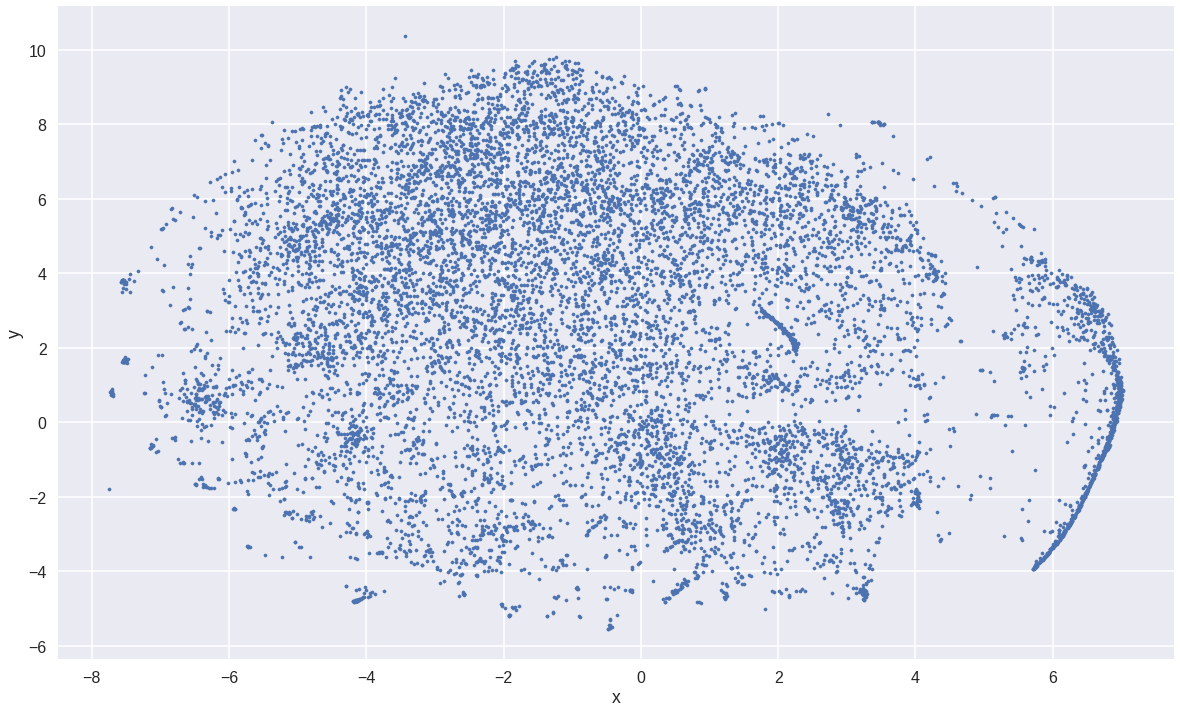

In [360]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [372]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [1]:
plot_region(x_bounds=(1.8, 2.2), y_bounds=(2, 4))

NameError: name 'plot_region' is not defined

### Explore semantic similarities between skills

**Words closest to the given word**

In [396]:
s = "ontwikkelaar"
for i in sentence_to_wordlist(s):
    try:
        print( i, thrones2vec.most_similar(i)[:3])
    except KeyError:
        print("KeyError", i)

ontwikkelaar [(u'mimimaal', 0.8603966236114502), (u'developer', 0.8517457246780396), (u'kwaliteiten', 0.8246134519577026)]


**Linear relationships between word pairs**

In [389]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [392]:
nearest_similarity_cosmul("dynamics", "windows", "azure")

dynamics is related to windows, as power is related to azure


u'power'

## Scratch paper

## Named Entity Recognitation

In [ ]:
with open('.txt', 'r') as f:
    sample = f.read()

In [55]:
from nltk import word_tokenize, pos_tag, ne_chunk
print (ne_chunk(pos_tag(word_tokenize(sent_list))))



TypeError: expected string or buffer

In [57]:
for i in sent_list:
    match = ne_chunk(pos_tag(word_tokenize(i)))
    print (match)

(S
  (PERSON Inzet/NNP)
  (ORGANIZATION Erik/NNP)
  van/NN
  (PERSON Peperstraten/NNP Philips/NNP))
(S
  20/CD
  -/:
  Vakantievervanging/VBG
  (PERSON Jaap/NNP Onrust/NNP)
  ./.
  1e/2e/CD
  lijns/JJ
  ondersteuning/NN
  ./.)
(S
  21/CD
  -/:
  (GPE Netwerkbeheerder/NN)
  tbv/NN
  het/NN
  in/IN
  kaart/NN
  brengen/NN
  van/NN
  de/IN
  (ORGANIZATION IST/NNP)
  situatie/VBD
  van/JJ
  netwerk/JJ
  en/NN
  Server/NNP
  ./.)
(S 21/CD -/: (PERSON Installatie/NNP W2000/NNP) server/NN)
(S 24/CD -/: (GPE Mediaan/NNP) beheerder/NN Infrastructuur/NNP ./.)
(S
  26/CD
  -/:
  (FACILITY Site/NNP Design/NNP)
  ,/,
  (PERSON Application/NNP Hosting/NNP)
  and/CC
  Planning/NNP
  Resource/NNP
  ./.
  Update/VB
  the/DT
  (FACILITY Site/NNP Design/NNP Sheet/NNP)
  to/TO
  add/VB
  additional/JJ
  infrastructure/NN
  hardware/NN
  for/IN
  requests/NNS
  in/IN
  the/DT
  pipeline/NN
  ./.
  Check/VB
  to/TO
  determine/VB
  the/DT
  required/JJ
  infrastructure/NN
  upgrades/NNS
  ./.
  Order/VB
  t

UnicodeEncodeError: 'ascii' codec can't encode characters in position 0-1: ordinal not in range(128)

In [55]:
stopwoorden1 = """
	aan          
	aangaande    
	aangezien    
	achter       
	achterna     
	afgelopen    
	al           
	aldaar       
	aldus        
	alhoewel     
	alias        
	alle         
	allebei      
	alleen       
	alsnog       
	altijd       
	altoos       
	ander        
	andere       
	anders       
	anderszins   
	behalve      
	behoudens    
	beide        
	beiden       
	ben          
	beneden      
	bent         
	bepaald      
	betreffende  
	bij          
	binnen       
	binnenin     
	boven        
	bovenal      
	bovendien    
	bovengenoemd 
	bovenstaand  
	bovenvermeld 
	buiten       
	daar         
	daarheen     
	daarin       
	daarna       
	daarnet      
	daarom       
	daarop       
	daarvanlangs 
	dan          
	dat          
	de           
	die          
	dikwijls     
	dit          
	door         
	doorgaand    
	dus          
	echter       
	eer          
	eerdat       
	eerder       
	eerlang      
	eerst        
	elk          
	elke         
	en           
	enig         
	enigszins    
	enkel        
	er           
	erdoor       
	even         
	eveneens     
	evenwel      
	gauw         
	gedurende    
	geen         
	gehad        
	gekund       
	geleden      
	gelijk       
	gemoeten     
	gemogen      
	geweest      
	gewoon       
	gewoonweg    
	haar         
	had          
	hadden       
	hare         
	heb          
	hebben       
	hebt         
	heeft        
	hem          
	hen          
	het          
	hierbeneden  
	hierboven    
	hij          
	hoe          
	hoewel       
	hun          
	hunne        
	ik           
	ikzelf       
	in           
	inmiddels    
	inzake       
	is           
	jezelf       
	jij          
	jijzelf      
	jou          
	jouw         
	jouwe        
	juist        
	jullie       
	kan          
	klaar        
	kon          
	konden       
	krachtens    
	kunnen       
	kunt         
	later        
	liever       
	maar         
	mag          
	meer         
	met          
	mezelf       
	mij          
	mijn         
	mijnent      
	mijner       
	mijzelf      
	misschien    
	mocht        
	mochten      
	moest        
	moesten      
	moet         
	moeten       
	mogen        
	na           
	naar         
	nadat        
	net          
	niet         
	noch         
	nog          
	nogal        
	nu           
	of           
	ofschoon     
	om           
	omdat        
	omhoog       
	omlaag       
	omstreeks    
	omtrent      
	omver        
	onder        
	ondertussen  
	ongeveer     
	ons          
	onszelf      
	onze         
	ook          
	op           
	opnieuw      
	opzij        
	over         
	overeind     
	overigens    
	pas          
	precies      
	reeds        
	rond         
	rondom       
	sedert       
	sinds        
	sindsdien    
	slechts      
	sommige      
	spoedig      
	steeds       
	tamelijk     
	tenzij       
	terwijl      
	thans        
	tijdens      
	toch         
	toen         
	toenmaals    
	toenmalig    
	tot          
	totdat       
	tussen       
	uit          
	uitgezonderd 
	vaakwat      
	van          
	vandaan      
	vanuit       
	vanwege      
	veeleer      
	verder       
	vervolgens   
	vol          
	volgens      
	voor         
	vooraf       
	vooral       
	vooralsnog   
	voorbij      
	voordat      
	voordezen    
	voordien     
	voorheen     
	voorop       
	vooruit      
	vrij         
	vroeg        
	waar         
	waarom       
	wanneer      
	want         
	waren        
	was          
	weer         
	weg          
	wegens       
	wel          
	weldra       
	welk         
	welke        
	wie          
	wiens        
	wier         
	wij          
	wijzelf      
	zal          
	ze           
	zelfs        
	zichzelf     
	zij          
	zijn         
	zijne        
	zo           
	zodra        
	zonder       
	zou          
	zouden       
	zowat        
	zulke        
	zullen       
	zult         
""".split()

stopwoorden2 = """aan
af
al
alles
als
altijd
andere
ben
bij
daar
dan
dat
de
der
deze
die
dit
doch
doen
door
dus
een
eens
en
er
ge
geen
geweest
haar
had
heb
hebben
heeft
hem
het
hier
hij
hoe
hun
iemand
iets
ik
in
is
ja
je 
kan
kon
kunnen
maar
me
meer
men
met
mij
mijn
moet
na
naar
niet
niets
nog
nu
of
om
omdat
ons
ook
op
over
reeds
te
tegen
toch
toen
tot
u
uit
uw
van
veel
voor
want
waren
was
wat
we
wel
werd
wezen
wie
wij
wil
worden
zal
ze
zei
zelf
zich
zij
zijn
zo
zonder
zou""".split()

stopwoorden3 = """de
en
van
ik
te
dat
die
in
een
hij
het
niet
zijn
is
was
op
aan
met
als
voor
had
er
maar
om
hem
dan
zou
of
wat
mijn
men
dit
zo
door
over
ze
zich
bij
ook
tot
je
mij
uit
der
daar
haar
naar
heb
hoe
heeft
hebben
deze
u
want
nog
zal
me
zij
nu
ge
geen
omdat
iets
worden
toch
al
waren
veel
meer
doen
toen
moet
ben
zonder
kan
hun
dus
alles
onder
ja
eens
hier
wie
werd
altijd
doch
wordt
wezen
kunnen
ons
zelf
tegen
na
reeds
wil
kon
niets
uw
iemand
geweest
andere""".split()

stopwoorden3 = """aan
achte
achter
af
al
alle
alleen
alles
als
ander
anders
beetje
behalve
beide
beiden
ben
beneden
bent
bij
bijna
bijv
blijkbaar
blijken
boven
bv
daar
daardoor
daarin
daarna
daarom
daaruit
dan
dat
de
deden
deed
derde
derhalve
dertig
deze
dhr
die
dit
doe
doen
doet
door
drie
duizend
echter
een
eens
eerst
eerste
eigen
eigenlijk
elk
elke
en
enige
er
erg
ergens
etc
etcetera
even
geen
genoeg
geweest
haar
haarzelf
had
hadden
heb
hebben
hebt
hedden
heeft
heel
hem
hemzelf
hen
het
hetzelfde
hier
hierin
hierna
hierom
hij
hijzelf
hoe
honderd
hun
ieder
iedere
iedereen
iemand
iets
ik
in
inderdaad
intussen
is
ja
je
jij
jijzelf
jou
jouw
jullie
kan
kon
konden
kun
kunnen
kunt
laatst
later
lijken
lijkt
maak
maakt
maakte
maakten
maar
mag
maken
me
meer
meest
meestal
men
met
mevr
mij
mijn
minder
miss
misschien
missen
mits
mocht
mochten
moest
moesten
moet
moeten
mogen
mr
mrs
mw
na
naar
nam
namelijk
nee
neem
negen
nemen
nergens
niemand
niet
niets
niks
noch
nochtans
nog
nooit
nu
nv
of
om
omdat
ondanks
onder
ondertussen
ons
onze
onzeker
ooit
ook
op
over
overal
overige
paar
per
recent
redelijk
samen
sinds
steeds
te
tegen
tegenover
thans
tien
tiende
tijdens
tja
toch
toe
tot
totdat
tussen
twee
tweede
u
uit
uw
vaak
van
vanaf
veel
veertig
verder
verscheidene
verschillende
via
vier
vierde
vijf
vijfde
vijftig
volgend
volgens
voor
voordat
voorts
waar
waarom
waarschijnlijk
wanneer
waren
was
wat
we
wederom
weer
weinig
wel
welk
welke
werd
werden
werder
whatever
wie
wij
wijzelf
wil
wilden
willen
word
worden
wordt
zal
ze
zei
zeker
zelf
zelfde
zes
zeven
zich
zij
zijn
zijzelf
zo
zoals
zodat
zou
zouden
zulk
zullen""".split()

stopwoorden4 = """aan
af
al
als
bij
dan
dat
die
dit
een
en
er
had
heb
hem
het
hij
hoe
hun
ik
in
is
je
kan
me
men
met
mij
nog
nu
of
ons
ook
te
tot
uit
van
was
wat
we
wel
wij
zal
ze
zei
zij
zo
zou""".split()

stopwoorden5 = """aan
af
al
als
bij
dan
dat
die
dit
een
en
er
had
heb
hem
het
hij
hoe
hun
ik
in
is
je
kan
me
men
met
mij
nog
nu
of
ons
ook
te
tot
uit
van
was
wat
we
wel
wij
zal
ze
zei
zij
zo
zou""".split()

stopwoorden6 = """de
en
van
ik
te
dat
die
in
een
hij
het
niet
zijn
is
was
op
aan
met
als
voor
had
er
maar
om
hem
dan
zou
of
wat
mijn
men
dit
zo
door
over
ze
zich
bij
ook
tot
je
mij
uit
der
daar
haar
naar
heb
hoe
heeft
hebben
deze
u
want
nog
zal
me
zij
nu
ge
geen
omdat
iets
worden
toch
al
waren
veel
meer
doen
toen
moet
ben
zonder
kan
hun
dus
alles
onder
ja
eens
hier
wie
werd
altijd
doch
wordt
wezen
kunnen
ons
zelf
tegen
na
reeds
wil
kon
niets
uw
iemand
geweest
andere""".split()